THIS IS A CHANGE 

In [1]:
from tqdm import tqdm
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import model
import metrics
import config
import utis

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config
import glob

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

/share/etud/e2008984/miniconda3/envs/env_thesis/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')[:80]
mask_paths = glob.glob(MASK_PATH +'/*.tif')[:80]


### Weights and Biases

In [3]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Dataloader

In [4]:
# Dataset Object 
print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
dataset = HistoricalImagesDataset(image_paths, mask_paths)
data = next(iter(dataset))
print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
print('Splitting data into TRAIN, VAL and TEST')
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

Number of image patches: 80 
Number of mask patches: 80
shape image torch.Size([1, 512, 512]) shape mask torch.Size([1, 512, 512])
Splitting data into TRAIN, VAL and TEST
Training set size:  40
Validation set size:  20
Testing set size:  20


### Check if CUDA is available

In [5]:
print(f'{config.DEVICE} is available')

cpu is available


### Training

In [6]:
def train(model, dataloader, optim, lossFunc):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0

    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward
        # with torch.cuda.amp.autocast(): # setting float16 to speed up the traiing
        pred = model(x)
        loss = lossFunc(pred, y)
        
        optim.zero_grad()  # zero out any previously accumulated gradients
        loss.backward() # obtain the gradients with respect to the loss
        opt.step() # perform one step of gradient descendent
        totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics
        accuracy += 100*(metrics.pixel_accuracy(pred, y))
        iou += metrics.jaccard_idx(pred, y)
        
        # update tqdm
        loop.set_postfix(loss=loss.item(), acc = accuracy, iou=iou)
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)

    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc loss
    training_history["IoU"].append(avgIOU) # save the acc loss
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [7]:
def validation(model, dataloader, lossFunc):
    # Save total train loss
    totalValLoss = 0
    # metrics
    accuracy_val = 0
    iou_val = 0
    
    iter = 0
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x_val, y_val) in val_dataloader:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics
            accuracy_val += 100*(metrics.pixel_accuracy(pred_val, y_val))
            iou_val += metrics.jaccard_idx(pred_val, y_val)
            
                
            # Plotting Val 
            # pred = F.softmax(pred_val, dim=0).numpy() # get the prediction 
            # pred = np.squeeze(np.where(pred_val > 0.25, 1, 0))
            # print(pred.shape)
            gt = np.squeeze(y_val.data.cpu().numpy()[0])
            pred = np.squeeze(pred_val.sigmoid().numpy())
            print('hey', pred.shape)
            _, ax = plt.subplots(1, 2)
            ax[0].imshow(gt)
            ax[0].set_title('Ground Truth')
            ax[1].imshow(pred[0])
            ax[1].set_title('Prediction')

            plt.show()
            
            # iter += 1
            
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc loss
    validation_history["IoU_val"].append(avgIOU) # save the acc loss
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

### MAIN

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


Training the network for 5 epochs, with a batch size of 5 and 1 iterations per epoch 🤗


100%|██████████| 8/8 [01:41<00:00, 12.20s/it, acc=94.1, iou=1.77, loss=0.999]
                                                                             

hey (5, 512, 512)


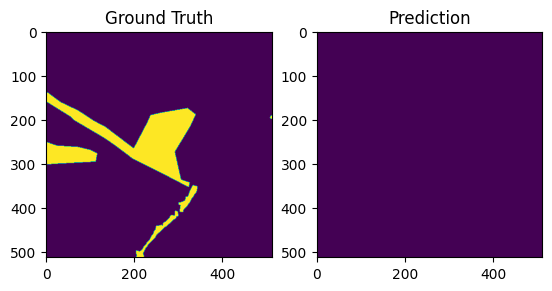

hey (5, 512, 512)


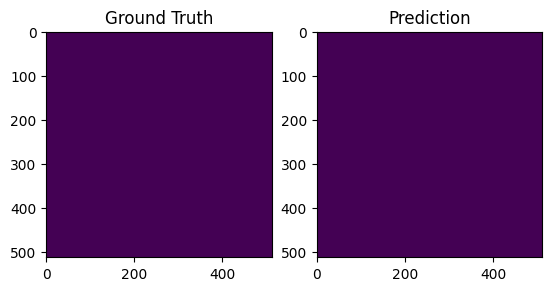

hey (5, 512, 512)


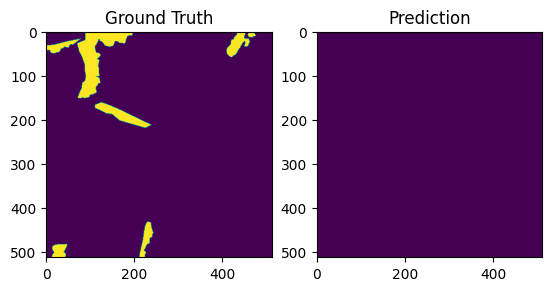

hey (5, 512, 512)


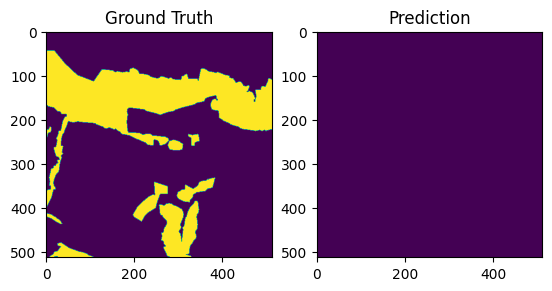

100%|██████████| 8/8 [01:20<00:00, 10.41s/it, acc=70.9, iou=1.84, loss=0.998]
                                                                             

hey (5, 512, 512)


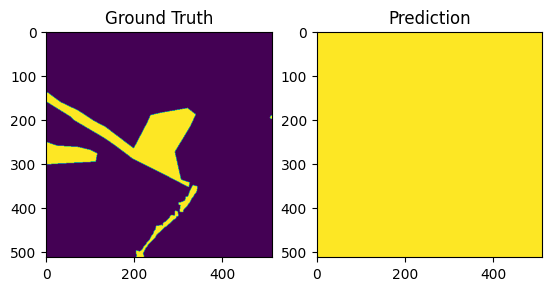

hey (5, 512, 512)


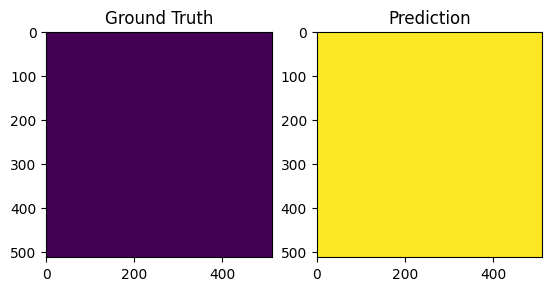

hey (5, 512, 512)


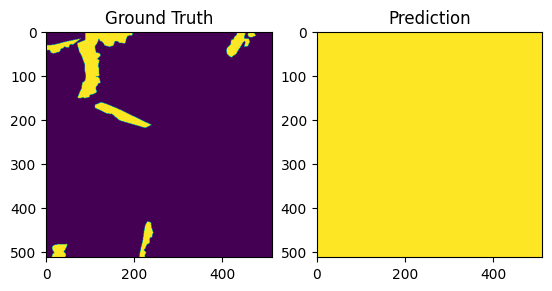

hey (5, 512, 512)


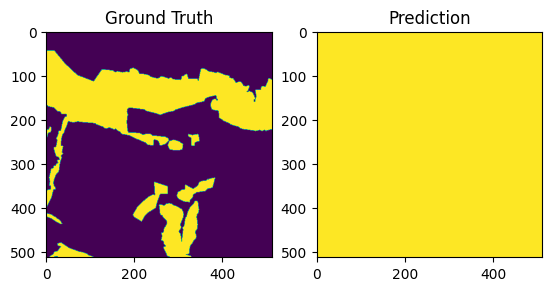

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# Initialize our model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[]}

# initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(unet, log="all")

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE} and {config.BATCH_SIZE // config.NUM_EPOCHS} iterations per epoch 🤗''') # try with logger

for e in tqdm(range(config.NUM_EPOCHS)):
    trained = train(unet, train_dataloader, opt, lossFunc)
    validated = validation(unet, val_dataloader, lossFunc)
    
    # Save best model
    if validated['val_accuracy'][-1] > best_accuracy : # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['val_accuracy'][-1]

In [ ]:
unet

### Predictions

In [ ]:
def save_predictions_as_imgs():
    pass

# Old Implementation


In [ ]:
# Training the network 
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE} and {trainSteps} iterations per epoch 🤗''')

for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    model.train()

    # For each epoch initialize the: 
    # total training
    totalTrainLoss = 0
    totalValLoss = 0

    # number of correctly classified pixels and the total number of pixels
    train_correct = 0
    total_n_pixels = 0

    # loop over the training set
    loop = tqdm(train_dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward
        with torch.cuda.amp.autocast(): # setting float16 to speed up the traiing
            pred = model(x)
            loss = lossFunc(pred, y)
        
        opt.zero_grad()  # zero out any previously accumulated gradients
        loss.backward() # obtain the gradients with respect to the loss
        opt.step() # perform one step of gradient descendent
        totalTrainLoss += loss  # add the loss to the total training loss so far  
        
        # update tqdm
        loop.set_postfix(loss=loss.item())
        
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x_val, y_val) in val_dataloader:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss

    # calculate the average training and validation loss PER EPOCH
    avgTrainLoss = totalTrainLoss / trainSteps 
    avgValLoss = totalValLoss / valSteps
    
    print(f'avg train loss {avgTrainLoss}')
    print('val loss', avgValLoss)

    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss

    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))

print(training_history)

In [ ]:
validation_history['avg_val_loss']

In [ ]:
training_history['avg_train_loss']

In [ ]:
plt.figure()
plt.plot(training_history['avg_train_loss'], label= 'train')
plt.plot(validation_history['avg_val_loss'], label='val')
plt.legend()
plt.show()